# Bone Fracture Detection (Fracture | No-Fracture classes)

### 1) Import libraries

In [1]:
!pip install opendatasets

In [2]:
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models, callbacks, regularizers
from sklearn.metrics import f1_score, classification_report, confusion_matrix, roc_auc_score
from PIL import Image, ImageEnhance
import tensorflow as tf
import opendatasets as od
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
import random

### 2) Download the dataset

In [3]:
# Download the dataset using `opendatasets` library
od.download("https://www.kaggle.com/datasets/cjinny/mura-v11/data")
print("--Download Completed--")

Dataset URL: https://www.kaggle.com/datasets/cjinny/mura-v11


100%|██████████| 3.14G/3.14G [00:55<00:00, 61.1MB/s]



--Download Completed--


### 3) Load and Inspect the dataset and its structure

#### CSV files

1.   `train_image_paths.csv`
2.   `train_labeled_studies.csv`
3.   `valid_image_paths.csv`
4.   `valid_labeled_studies.csv`


In [4]:
#---------------------------
# Read CSV files to inspect
#---------------------------

#----- Train -----
train_img_paths = pd.read_csv("/content/mura-v11/MURA-v1.1/train_image_paths.csv")
train_lbl_std = pd.read_csv("/content/mura-v11/MURA-v1.1/train_labeled_studies.csv")

#----- Validation -----
val_img_paths = pd.read_csv("/content/mura-v11/MURA-v1.1/valid_image_paths.csv")
val_lbl_std = pd.read_csv("/content/mura-v11/MURA-v1.1/valid_labeled_studies.csv")

#----- Inspect -----
print(f"Shapes of train dataframes:\ntrain_img_paths: {train_img_paths.shape}\ntrain_lbl_std: {train_lbl_std.shape}")
print(50*"-")
print(f"Shapes of validation dataframes:\nval_img_paths: {val_img_paths.shape}\nval_lbl_std: {val_lbl_std.shape}")
print(50*"-")
print(f"Total image counts: {train_img_paths.shape[0] + val_img_paths.shape[0]}")
print(f"Total study label counts: {train_lbl_std.shape[0] + val_lbl_std.shape[0]}")



Shapes of train dataframes:
train_img_paths: (36807, 1)
train_lbl_std: (13456, 2)
--------------------------------------------------
Shapes of validation dataframes:
val_img_paths: (3196, 1)
val_lbl_std: (1198, 2)
--------------------------------------------------
Total image counts: 40003
Total study label counts: 14654


In [5]:
#--------------------------------------------
# Change dataframes columns name for clarity
#--------------------------------------------

# Get cols names & store them in a list
train_img_p_name =  train_img_paths.columns.to_list()
train_lbl_name = train_lbl_std.columns.to_list()
val_img_p_name = val_img_paths.columns.to_list()
val_lbl_name = val_lbl_std.columns.to_list()

# List of dataframes
dfs = [train_img_paths, val_img_paths, train_lbl_std, val_lbl_std]
# List of cols names
names = [train_img_p_name, val_img_p_name, train_lbl_name, val_lbl_name]

# Loop thorough dfs and names lists
for df, name in zip(dfs, names):
    # If there are 2 cols change their names
    if len(name) == 2:
        df.rename(columns={name[0]: "dir_path", name[1]: "label"}, inplace=True)
    # Otherwise change the only one col's name
    else:
        df.rename(columns={name[0]: "dir_path"}, inplace=True)

# Dataframes after changes
print(train_img_paths.head(),
      val_img_paths.head(),
      train_lbl_std.head(),
      val_lbl_std.head(), sep="\n\n", end="\n\n")

# Show directory paths
print("Smaples of paths:")
print("- The first two are image paths\n- The second two are study paths")
for row in dfs:
    print(row.iat[0,0])

                                            dir_path
0  MURA-v1.1/train/XR_SHOULDER/patient00001/study...
1  MURA-v1.1/train/XR_SHOULDER/patient00001/study...
2  MURA-v1.1/train/XR_SHOULDER/patient00002/study...
3  MURA-v1.1/train/XR_SHOULDER/patient00002/study...
4  MURA-v1.1/train/XR_SHOULDER/patient00002/study...

                                            dir_path
0  MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...
1  MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...
2  MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...
3  MURA-v1.1/valid/XR_WRIST/patient11186/study1_p...
4  MURA-v1.1/valid/XR_WRIST/patient11186/study1_p...

                                            dir_path  label
0  MURA-v1.1/train/XR_SHOULDER/patient00002/study...      1
1  MURA-v1.1/train/XR_SHOULDER/patient00003/study...      1
2  MURA-v1.1/train/XR_SHOULDER/patient00004/study...      1
3  MURA-v1.1/train/XR_SHOULDER/patient00005/study...      1
4  MURA-v1.1/train/XR_SHOULDER/patient00006/study...      1

 

label
0    661
1    537
Name: count, dtype: int64

label
0    8280
1    5176
Name: count, dtype: int64


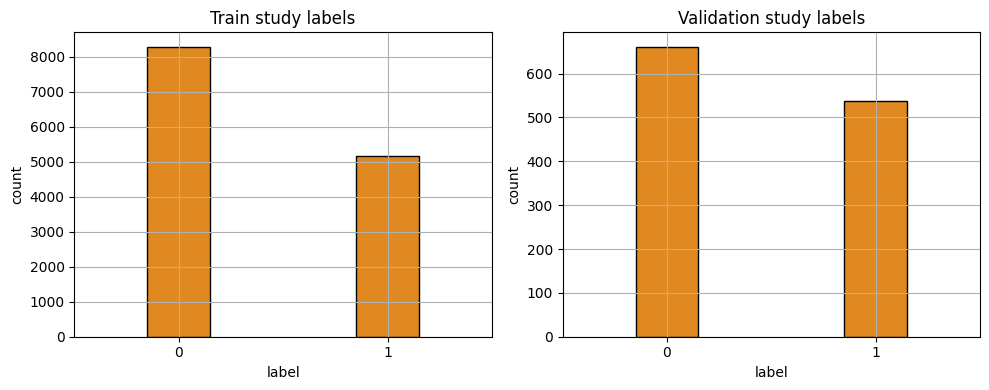

In [6]:
#---------------------------------------
# Check distribution of classes/labels based on study folders
#---------------------------------------

# Print ditribution of classes
print(val_lbl_std['label'].value_counts(),
train_lbl_std['label'].value_counts(), sep="\n\n")

# Vsialize distribution of classes
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
for i, df in enumerate(dfs[2:]):
    # Adjust plots
    sns.countplot(data=df, x='label', width=0.3,
                   color='darkorange', edgecolor='black', ax=axes[i])
    # Add title
    axes[i].set_title(['Train study labels', 'Validation study labels'][i])
    # Add grids
    axes[i].grid()

plt.tight_layout()
plt.show()

### 4) Preprocessing / Engineering features

In [7]:
#---------------------------------------------
# Preprocess and engineer features,
# split then build final datasets
#---------------------------------------------

# Specify parameters
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
RANDOM_STATE = 42

# 1) Get image paths and labels
#------------------------------

def extract_img_path_label(df):
    """
    A function to extract image paths and labels.
    Input: A dataframe composed of `dir_path` & `label` cols
    Output: Two lists `image_paths` & `image_labels`
    """
    # Specify root path
    root_path = "/content/mura-v11/"

    # Lists to store paths and labels
    image_paths = []
    image_labels = []

    # Loop through the dataframe
    for _, row in df.iterrows():
        # Get path and label
        path = row['dir_path']
        label = row['label']

        # Loop through the folder consist of images (in our case study#_pos/neg)
        for filename in os.listdir(os.path.join(root_path, path)):
            # Make sure files are the in correct formats; Skip macOS metadata files starting with '._'
            if filename.lower().endswith(('.png', '.jpg', '.jpeg')) and not filename.startswith('._'):
                # Add image path and label to their lists
                image_paths.append(os.path.join(root_path, path, filename))
                image_labels.append(label)

    return image_paths, image_labels

# Call extract_img_path_label func to Get image paths and labels
# -- Train --
train_image_paths, train_image_labels = extract_img_path_label(train_lbl_std)
# -- Validation (For the final evaluation) --
val_image_paths, val_image_labels = extract_img_path_label(val_lbl_std)


# Check lists
print("Smaples:\n")
print(f"Train image paths (first 2):\n{train_image_paths[:2]}")
print(f"Train image labels (first 2):\n{train_image_labels[:2]}")
print(50*"-")
print(f"Validation image paths (first 2):\n{val_image_paths[:2]}")
print(f"Validation image labels (first 2):\n{val_image_labels[:2]}")
print(50*"-")
# Check counts
print(f"Train image path counts: {len(train_image_paths)}")
print(f"Train image label counts: {len(train_image_labels)}")
print(50*"-")
print(f"Validation image path counts: {len(val_image_paths)}")
print(f"Validation image label counts: {len(val_image_labels)}")

Smaples:

Train image paths (first 2):
['/content/mura-v11/MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/image3.png', '/content/mura-v11/MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/image2.png']
Train image labels (first 2):
[1, 1]
--------------------------------------------------
Validation image paths (first 2):
['/content/mura-v11/MURA-v1.1/valid/XR_WRIST/patient11186/study1_positive/image2.png', '/content/mura-v11/MURA-v1.1/valid/XR_WRIST/patient11186/study1_positive/image1.png']
Validation image labels (first 2):
[1, 1]
--------------------------------------------------
Train image path counts: 36805
Train image label counts: 36805
--------------------------------------------------
Validation image path counts: 3193
Validation image label counts: 3193


In [8]:
# 2) Split train dataset into train and test sets
#------------------------------
train_paths, test_paths, y_train, y_test = train_test_split(
    train_image_paths, train_image_labels, test_size=0.2,
    random_state=RANDOM_STATE, stratify=train_image_labels
)

# Check lists after split
print(f"Train samples: {len(train_paths)}\nTest samples: {len(test_paths)}")


Train samples: 29444
Test samples: 7361


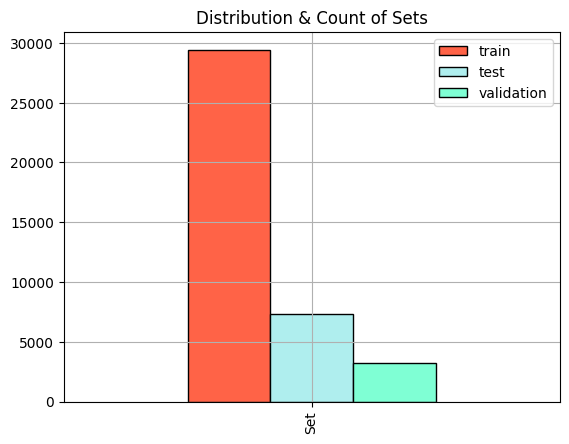

In [9]:
#------------------------------------------------------------------------
# Visualize distribution & count of data in train, test, and validation sets
#------------------------------------------------------------------------

# Build a dataframe of distribution & count of sets
dist = {"train": len(train_paths), "test": len(test_paths), "validation": len(val_image_paths)}
dist_df = pd.DataFrame(dist, index=['Set'])
# Visualize with barplots
dist_df.plot.bar(color=['tomato', 'paleturquoise', 'aquamarine'], edgecolor='k')
plt.title('Distribution & Count of Sets')
plt.grid()
plt.show()


> One important thing, is that the `validation data` is going to be used for the final evaluation in addition to the `test set` which is 20% of `train data`.

Label
0        17548
1        11896
Name: count, dtype: int64


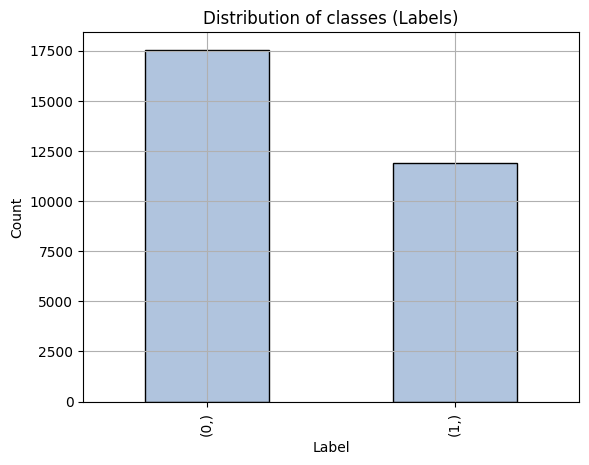

In [16]:
#------------------------------------------------
# Check distributions of classes based on images count in train datset
#------------------------------------------------

# Count labels in the dataframe
clss_df = pd.DataFrame(y_train, columns=['Label'])
c = clss_df.value_counts()
# Print the dataframe
print(c)
# Vsialize distribution of classes
c.plot.bar(color='lightsteelblue', edgecolor='k')
plt.title('Distribution of classes (Labels)')
plt.ylabel('Count')
plt.grid()
plt.show()


In [64]:
# 3) Build core functions for loading images, preprocessing,
# converting into tensors and builing the final datasets
#------------------------------

#----- Load images -----
def load_image(path):
    """
    A function to load images & preprocess.
    Input: Path
    Output: Image arrays with the type float32
    """
    try:
        # Convert tensor to string
        path = path.numpy().decode('utf-8')
        # Check file exists
        if not os.path.isfile(path):
            # Print the situation
            print(f"File does not exist: {path}")
            return np.zeros((IMAGE_SIZE[0], IMAGE_SIZE[1], 1), dtype=np.float32)
        # Load images with the targeted size
        img = tf.keras.utils.load_img(path, target_size=IMAGE_SIZE, color_mode="grayscale")
        # Convert images into arrays and normalize them
        img_array = tf.keras.utils.img_to_array(img) / 255.0
        # Convert arrays' type into float32
        return img_array.astype(np.float32)
    except Exception as e:
        print(f"Error loading image {path}: {e}")
        return np.zeros((IMAGE_SIZE[0], IMAGE_SIZE[1], 1), dtype=np.float32)


#----- Convert into tensor -----
def tf_load_image(path, label=None):
    """
    A function to convert loaded & preprocessed images into tensors.
    Input: Path | label
    Output: images & labels
    """
    # Conversion
    img = tf.py_function(
        func=load_image,
        inp=[path],
        Tout=tf.float32
    )

    # Specify outputs shapes and types
    img.set_shape([IMAGE_SIZE[0], IMAGE_SIZE[1], 1])

    if label is not None:
        label.set_shape([])

    return img, label


#----- Create dataset -----
def create_dataset(paths, labels):
    """
    A function to create the final datasets.
    Input: Paths | Labels
    Output: Dataset
    """
    # tf.data pipline
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    # Map `tf_load_image` on `ds`
    ds = ds.map(tf_load_image, num_parallel_calls=tf.data.AUTOTUNE)
    # Shuffle, Batch, Prefetch
    ds = ds.shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

    return ds

# Call functions & make datasets
# Training & Testing
train_ds = create_dataset(train_paths, y_train)
test_ds = create_dataset(test_paths, y_test)
# Validation (For final evaluation)
val_ds = create_dataset(val_image_paths, val_image_labels)

# Check
print(f"Train Dataset: {len(train_ds)} batches")
print(f"test Dataset: {len(test_ds)} batches")
print(f"Validation Dataset: {len(val_ds)} batches")


Train Dataset: 921 batches
test Dataset: 231 batches
Validation Dataset: 100 batches


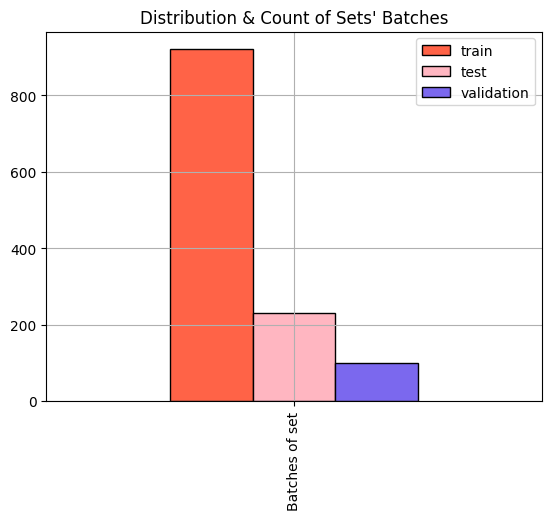

In [11]:
#------------------------------------------------------------------------
# Visualize distribution & count of data batches in train, test, and validation sets
#------------------------------------------------------------------------

# Build a dataframe of distribution & count of sets' batches
dist_ = {"train": len(train_ds), "test": len(test_ds), "validation": len(val_ds)}
dist_df_ = pd.DataFrame(dist_, index=['Batches of set'])
# Visualize with barplots
dist_df_.plot.bar(color=['tomato', 'lightpink', 'mediumslateblue'], edgecolor='k')
plt.title("Distribution & Count of Sets' Batches")
plt.grid()
plt.show()


**Explanation:** During working with the dataset and images I encountered an error: `PIL.UnidentifiedImageError`. The code snippet below worked as a debugger and I fix the problem which was `macOS metadata files starting with '._'`; It was handled.

In [ ]:
#----------------
# Debugging cell
#----------------

# Function to test if a file is a valid image
def test_image(path):
    try:
        if not os.path.isfile(path):
            print(f"File does not exist: {path}")
            return False
        img = Image.open(path)
        img.verify()  # Checks for file corruption
        img.close()
        return True
    except Exception as e:
        print(f"Invalid or corrupted image {path}: {e}")
        return False

# Test all paths in train_paths
print("Checking train_paths for invalid files...")
invalid_paths = [path for path in train_paths if not test_image(path)]

# Print results
if invalid_paths:
    print(f"Found {len(invalid_paths)} invalid or missing files:")
    for path in invalid_paths[:10]:  # Show first 10 for brevity
        print(path)
else:
    print("All files in train_paths seem valid.")



Checking train_paths for invalid files...
All files in train_paths seem valid.


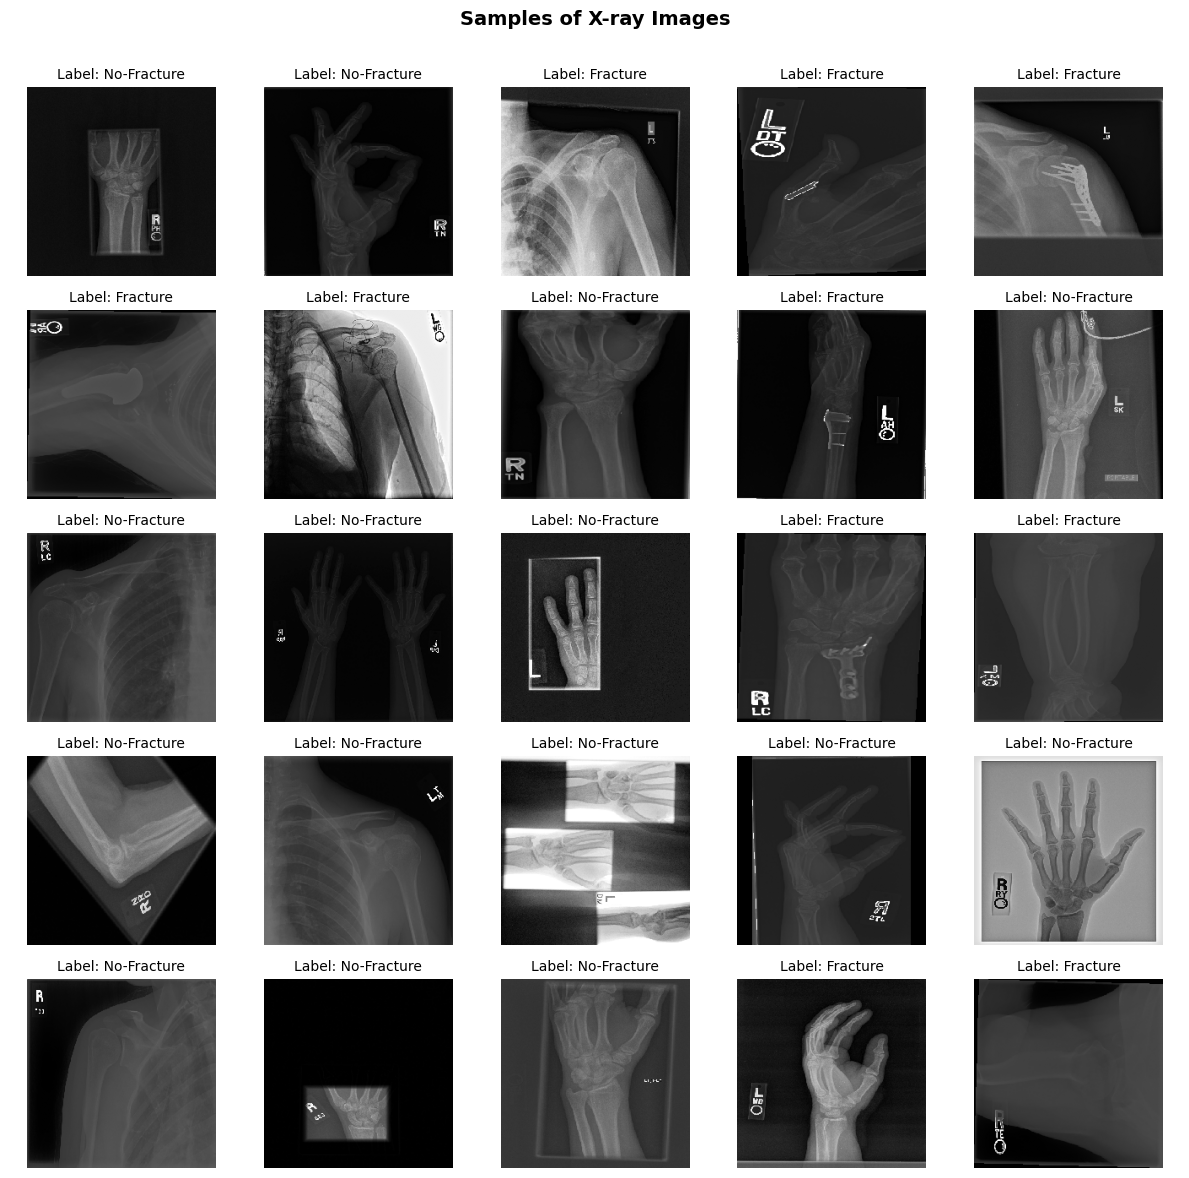

In [ ]:
#----------------------------------------------------
# Visualize a batch of images from the train dataset
#----------------------------------------------------

# Shuffle the dataset to get random samples
random_train_ds = train_ds.shuffle(buffer_size=1000, seed=RANDOM_STATE)

# Grab the first batch
for images, labels in train_ds.take(1):
    plt.figure(figsize=(12, 12))
    plt.title("Samples of X-ray Images", fontsize=14, fontweight="bold", y=1.05)
    plt.axis("off")
    # Show up to 25 images
    for i in range(min(25, len(images))):
        ax = plt.subplot(5, 5, i + 1)
        # Convert tensor to numpy and remove single channel dimension
        img = images[i].numpy().squeeze() # Shape: (224, 224)
        # Grayscale for X-rays
        plt.imshow(img, cmap='gray')
        # Display the label
        plt.title(f"Label: {'No-Fracture' if labels[i].numpy() == 0 else 'Fracture'}", fontsize=10)
        plt.axis("off")

    plt.tight_layout()
    plt.show()



### 5) Build the architecture of the model

In [ ]:
#--------------------------------------------------------------------
# Build the data augmentation techniques, architecture & the model,
# compile, fit, train and briefly evaluate
#--------------------------------------------------------------------

# Build the data augmentor
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),   # flip left-right
    layers.RandomRotation(0.1),        # rotate ±10%
    layers.RandomZoom(0.1),            # zoom in/out ±10%
    layers.RandomContrast(0.1)         # adjust contrast ±10%
])


# CNN architecture and model
model = models.Sequential([
    # Input layer
    layers.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 1)),
    # Data augmentor
    data_augmentation,
    # Convo layer 1
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    # Convo layer 2
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    # Convo layer 3
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    # Convo layer 4
    layers.Conv2D(256, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    # Global
    layers.GlobalAveragePooling2D(),
    # Hidden layer
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.7),
    # Output layer
    layers.Dense(1, activation='sigmoid')
])


# Compile: Set up optimizer, loss, metrics
model.compile(
    optimizer='Adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Set checkpoint to get and save the best version of the model
checkpoint = callbacks.ModelCheckpoint(
    filepath="cnn_best_model.keras",
    monitor="val_loss",
    mode="min",
    save_best_only=True,
    verbose=1
)

# Set early stopping to stop if the model didn't perform as expected after 3 epochs
early_stop = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# Save csv file of the evaluation metrics results
csv_logger = callbacks.CSVLogger("cnn_training_log.csv")

# Provide a summary of the model's architecture
model.summary()

# Fit and train
history = model.fit(
    train_ds,
    epochs=20,
    validation_data=test_ds,
    callbacks=[checkpoint, early_stop, csv_logger]
)

# Brief evaluation during training
model.evaluate(test_ds, verbose=2)



Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_26 (Sequential)      │ (None, 224, 224, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_44 (Conv2D)              │ (None, 222, 222, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_44 (MaxPooling2D) │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_45 (Conv2D)              │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_45 (MaxPooling2D) │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_46 (Conv2D)              │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_46 (MaxPooling2D) │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_47 (Conv2D)              │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_47 (MaxPooling2D) │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_11     │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_40 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 486,657 (1.86 MB)

 Trainable params: 486,657 (1.86 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
920/921 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.5952 - loss: 0.6752
Epoch 1: val_loss improved from inf to 0.66421, saving model to cnn_best_model.keras
921/921 ━━━━━━━━━━━━━━━━━━━━ 153s 161ms/step - accuracy: 0.5952 - loss: 0.6752 - val_accuracy: 0.5960 - val_loss: 0.6642
Epoch 2/20
920/921 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.5955 - loss: 0.6673
Epoch 2: val_loss improved from 0.66421 to 0.65894, saving model to cnn_best_model.keras
921/921 ━━━━━━━━━━━━━━━━━━━━ 202s 161ms/step - accuracy: 0.5955 - loss: 0.6673 - val_accuracy: 0.5960 - val_loss: 0.6589
Epoch 3/20
920/921 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.5975 - loss: 0.6635
Epoch 3: val_loss improved from 0.65894 to 0.65168, saving model to cnn_best_model.keras
921/921 ━━━━━━━━━━━━━━━━━━━━ 152s 162ms/step - accuracy: 0.5975 - loss: 0.6635 - val_accuracy: 0.6035 - val_loss: 0.6517
Epoch 4/20
921/921 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.6034 - loss: 0.6568
Epoch 4: val_loss impr

[0.5185187458992004, 0.7505773901939392]

[0.5185187458992004, 0.7505773901939392]

> Notice: Because of Colab's disconnection during training, in the output of training stage, `Epochs` alongside `metrics & brief evaluation` got a bit messy!

**The Final Evaluation on Test Set:**
- Loss: 0.5185187458992004
- Accuracy: 0.7505773901939392

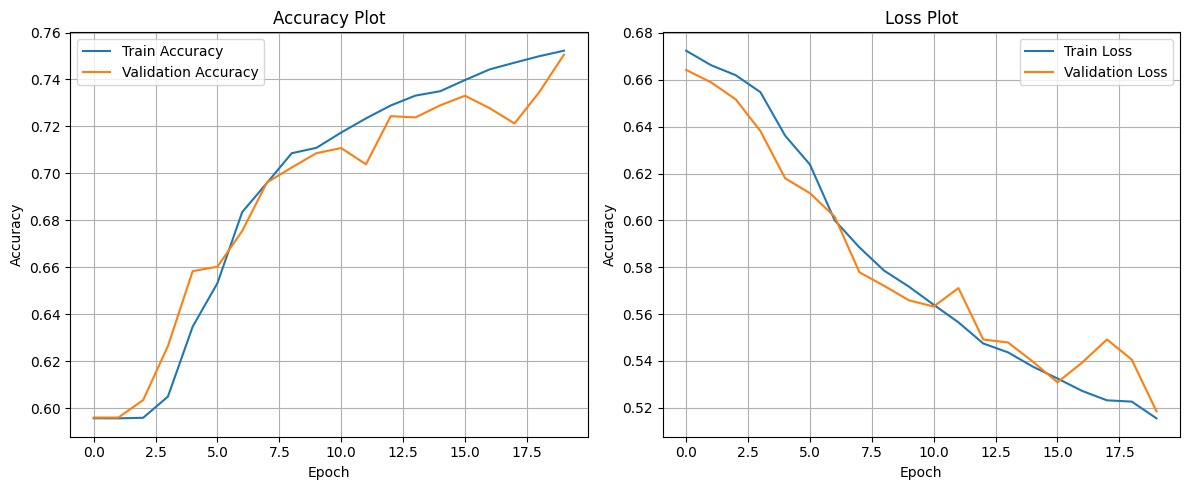

In [ ]:
#-------------------------------------
# Visualize performance of the model
#-------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Accuracy comparison
axes[0].plot(history.history['accuracy'], label="Train Accuracy")
axes[0].plot(history.history['val_accuracy'], label="Validation Accuracy")
axes[0].set_title("Accuracy Plot")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Accuracy")
axes[0].grid()
axes[0].legend()

# Loss comparison
axes[1].plot(history.history['loss'], label="Train Loss")
axes[1].plot(history.history['val_loss'], label="Validation Loss")
axes[1].set_title("Loss Plot")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")
axes[1].grid()
axes[1].legend()

plt.tight_layout()
plt.show()

### 6) Final detailed evaluation on the valiation data
> The dataset we've kept unseen (Hold-out dataset) for the final evaluation.

F1: 0.7158547021933074
ROC-AUC: 0.8042472763638623
Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.91      0.78      1667
           1       0.84      0.53      0.65      1526

    accuracy                           0.73      3193
   macro avg       0.76      0.72      0.71      3193
weighted avg       0.75      0.73      0.72      3193



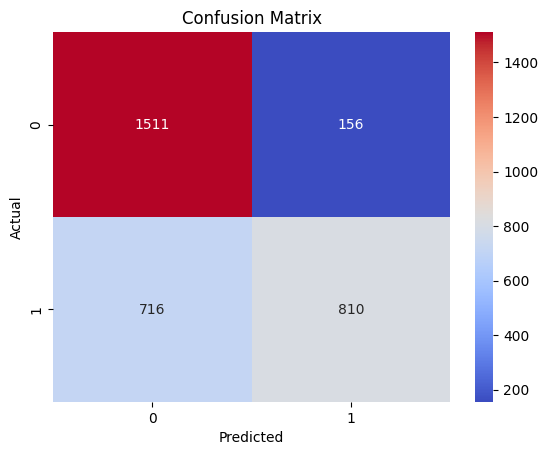

In [ ]:
#-------------------------------------------------------------------
# Final evaluation on the validation dataset and analyze the metrics
#-------------------------------------------------------------------

# Load the model
model = tf.keras.models.load_model("/content/cnn_best_model.keras")

# Collect predictions and true labels
all_labels = []
all_probs = []

for images, labels in val_ds:
    preds = model.predict(images, verbose=0).flatten()
    all_probs.extend(preds)
    all_labels.extend(labels.numpy())

# Convert probabilities to 0/1
threshold = 0.5
all_preds = (np.array(all_probs) > threshold).astype(np.int32)

# Metrics
f1 = f1_score(all_labels, all_preds, average='weighted')
roc_auc = roc_auc_score(all_labels, all_probs)
cr = classification_report(all_labels, all_preds)
cm = confusion_matrix(all_labels, all_preds)

print(f"F1: {f1}")
print(f"ROC-AUC: {roc_auc}")
print(f"Classification Report:\n{cr}")

# Confusion matrix visualization
sns.heatmap(cm, annot=True, cmap='coolwarm', fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()



### 7) Test on a single X-ray image

In [ ]:
#------------------------------
# Test on a single X-ray image
#------------------------------

def predictor(test_img):
    # Preprocess the image
    prp_img, _ = tf_load_image(test_img)

    # Ensure shape is (1, 224, 224, 1)
    if prp_img.ndim == 3:
        prp_img = np.expand_dims(prp_img, axis=0)  # add batch dimension
    if prp_img.shape[-1] != 1:
        prp_img = tf.image.rgb_to_grayscale(prp_img)  # force grayscale

    # Predict
    prediction = model.predict(prp_img, verbose=0)

    # Convert probabilities to 0/1
    threshold = 0.5
    final_pred = (prediction > threshold).astype(np.int32).flatten()[0]

    # Interpret the prediction
    intp_pred = "No Fracture" if final_pred == 0 else "Fracture"

    return prediction[0][0], final_pred, intp_pred


# Call the func
p, f, i = predictor("/content/testxray1.png")

# Print results
print(f"Class: {i}\nClass In Binary Format: {f}\nProbability: {p*100}")
